# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1

Importing data from Google Drive folder.

In [105]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

As usual, let us first import the needed Python libraries:

In [106]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

Let us load a train image:

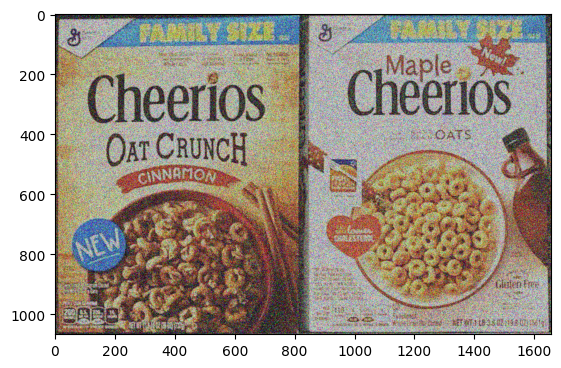

In [108]:
image = cv2.imread('dataset/scenes/scene1.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

We apply a Mediam filter

We the imports necessary functions and modules from the skimage library for image denoising. It then converts the input RGB image to floating point representation for further processing. Next, it estimates the average noise standard deviation across color channels of the noisy image and prints the result.


In [109]:
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float

image_float = img_as_float(image_rgb)

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(image_float, channel_axis=-1, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

Estimated Gaussian noise standard deviation = 0.28863532910425227


We applies the VisuShrink wavelet denoising method to the noisy image. It converts the image to the YCbCr color space for denoising, uses the VisuShrink method with soft thresholding, and scales the denoising parameter sigma by a factor of 1/4 of the estimated

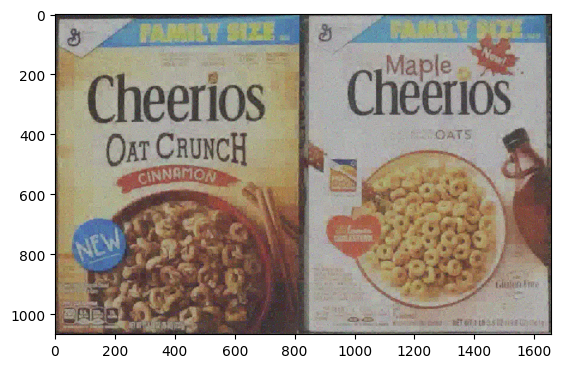

In [113]:
denoised_image = denoise_wavelet(
    image_float,
    channel_axis=-1,
    convert2ycbcr=True,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est / 4,
    rescale_sigma=True,
)

# Convert to uint8 and scale to [0, 255] range
denoised_image = (denoised_image * 255).astype(np.uint8)

plt.imshow(denoised_image)
plt.show()

Let us load a query image:

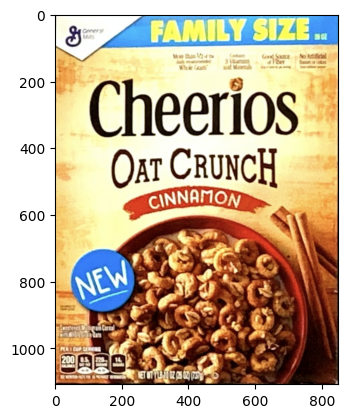

In [114]:
img_query = cv2.imread('dataset/models/ref1.png')
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

plt.imshow(img_query)
plt.show()

We write a modular program

In [115]:
from imutils.object_detection import non_max_suppression
import imutils

In [116]:
def load_images(models_dir, scenes_dir, track):
  model_images = {}
  scene_images = {}

  for model_name in sorted(os.listdir(models_dir)):
    name, ext = os.path.splitext(model_name)
    model_number = int(name.split('ref')[1])

    if track == 'A' and 1 <= model_number <= 14:
      model_images[name] = cv2.imread(os.path.join(models_dir, model_name))
    elif track == 'B' and 15 <= model_number <= 27:
      model_images[name] = cv2.imread(os.path.join(models_dir, model_name))

  for scene_name in sorted(os.listdir(scenes_dir)):
    name, ext = os.path.splitext(scene_name)
    scene_number = int(name.split('scene')[1])

    if track == 'A' and 1 <= scene_number <= 5:
      scene_images[name] = cv2.imread(os.path.join(scenes_dir, scene_name))
    elif track == 'B' and 6 <= scene_number <= 12:
      scene_images[name] = cv2.imread(os.path.join(scenes_dir, scene_name))


  return model_images, scene_images

In [ ]:
def preprocess_images(scene_images):
  preprocessed_scenes = {}

  for scene_name, scene_img in scene_images.items():
    scene_img = cv2.medianBlur(scene_img, 5)
    image_float = img_as_float(scene_img)
    sigma_est = estimate_sigma(image_float, channel_axis=-1, average_sigmas=True)

    denoised_image = denoise_wavelet(image_float, channel_axis=-1, convert2ycbcr=True,
                                     method='VisuShrink', mode='soft',
                                     sigma=sigma_est / 4, rescale_sigma=True)

    denoised_image = (denoised_image * 255).astype(np.uint8)
    # denoised_image = cv2.fastNlMeansDenoisingColored(denoised_image, None, 10, 10, 7, 21)
    preprocessed_scenes[scene_name] = denoised_image

  return preprocessed_scenes

In [158]:
def template_matching(scene_img, model_img):
  gray_scene = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
  gray_model = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)

  # Initialize list to store bounding boxes
  bounding_boxes = []
  rects = []

  w_img, h_img = gray_scene.shape[::-1]
  for scale in np.linspace(0.2, 1.0, 40):
    # Resize the image according to the scale, and keep track
    # of the ratio of the resizing
    resized = imutils.resize(gray_model, width = int(gray_model.shape[1] * scale))
    r = gray_model.shape[1] / float(resized.shape[1])

    # If the resized image is smaller than the template, then break
    if resized.shape[0] > h_img or resized.shape[1] > w_img:
      break

    # Perform template matching
    res = cv2.matchTemplate(gray_scene, resized, cv2.TM_CCOEFF_NORMED)
    threshold = 0.7
    loc = np.where(res >= threshold)

    # Loop over the starting (x, y)-coordinates again
    for pt in zip(*loc[::-1]):
       # Update our list of rectangles
       rects.append((pt[0], pt[1], pt[0] + resized.shape[1], pt[1] + resized.shape[0]))

  # Apply non-maxima suppression to the rectangles
  pick = non_max_suppression(np.array(rects))

  # Loop over the final bounding boxes
  for (startX, startY, endX, endY) in pick:

    # Calculate dimensions and position of bounding box
    w, h = (abs(startX - endX), abs(startY - endY))
    x_center = pt[0] + resized.shape[1] // 2
    y_center = pt[1] + resized.shape[0] // 2

    bounding_boxes.append({
        "position": (x_center, y_center),
        "width": resized.shape[1],
        "height": resized.shape[0]
        })

  return bounding_boxes

In [154]:
def generate_output(results, scene_img, show_bounding_boxes=False):
  for product_id, result in results.items():
    print("Product", product_id, "-", result["instances_found"], "instance(s) found:")
    for i, bbox in enumerate(result["bounding_boxes"], 1):
      print(f"Instance {i}: position: {bbox['position']}, width: {bbox['width']}px, height: {bbox['height']}px")
      if show_bounding_boxes:
        pt = bbox['position']
        w = bbox['width']
        h = bbox['height']

        tl = (int(pt[0] - w / 2), int(pt[1] - h / 2))
        br = (int(pt[0] + w / 2), int(pt[1] + h / 2))
        cv2.rectangle(scene_img, tl, br, (0, 0, 255), 3)
  print("\n")

  if show_bounding_boxes:
    plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
    plt.show()


Processing scene10
Product ref21 - 3 instance(s) found:
Instance 1: position: (1025, 662), width: 334px, height: 941px
Instance 2: position: (1025, 662), width: 334px, height: 941px
Instance 3: position: (1025, 662), width: 334px, height: 941px
Product ref22 - 4 instance(s) found:
Instance 1: position: (1300, 655), width: 334px, height: 941px
Instance 2: position: (1300, 655), width: 334px, height: 941px
Instance 3: position: (1300, 655), width: 334px, height: 941px
Instance 4: position: (1300, 655), width: 334px, height: 941px




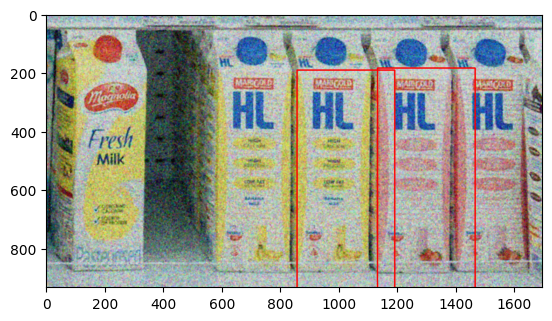


Processing scene11
Product ref17 - 3 instance(s) found:
Instance 1: position: (593, 467), width: 259px, height: 678px
Instance 2: position: (593, 467), width: 259px, height: 678px
Instance 3: position: (593, 467), width: 259px, height: 678px
Product ref23 - 3 instance(s) found:
Instance 1: position: (593, 466), width: 258px, height: 695px
Instance 2: position: (593, 466), width: 258px, height: 695px
Instance 3: position: (593, 466), width: 258px, height: 695px
Product ref24 - 4 instance(s) found:
Instance 1: position: (594, 471), width: 262px, height: 680px
Instance 2: position: (594, 471), width: 262px, height: 680px
Instance 3: position: (594, 471), width: 262px, height: 680px
Instance 4: position: (594, 471), width: 262px, height: 680px
Product ref25 - 3 instance(s) found:
Instance 1: position: (1377, 472), width: 262px, height: 680px
Instance 2: position: (1377, 472), width: 262px, height: 680px
Instance 3: position: (1377, 472), width: 262px, height: 680px




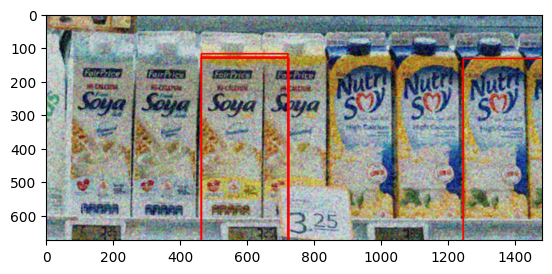


Processing scene12
Product ref26 - 2 instance(s) found:
Instance 1: position: (430, 452), width: 282px, height: 717px
Instance 2: position: (430, 452), width: 282px, height: 717px
Product ref27 - 2 instance(s) found:
Instance 1: position: (981, 470), width: 309px, height: 717px
Instance 2: position: (981, 470), width: 309px, height: 717px




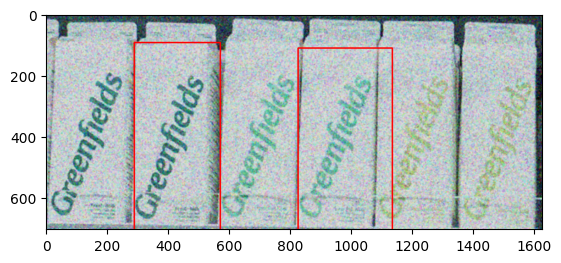


Processing scene6
Product ref15 - 3 instance(s) found:
Instance 1: position: (938, 619), width: 326px, height: 906px
Instance 2: position: (938, 619), width: 326px, height: 906px
Instance 3: position: (938, 619), width: 326px, height: 906px




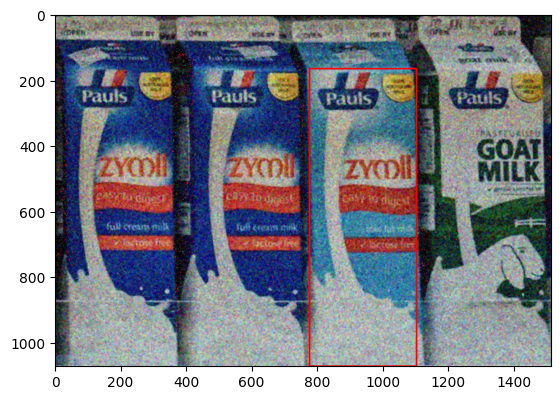


Processing scene7
Product ref16 - 2 instance(s) found:
Instance 1: position: (1066, 546), width: 283px, height: 784px
Instance 2: position: (1066, 546), width: 283px, height: 784px




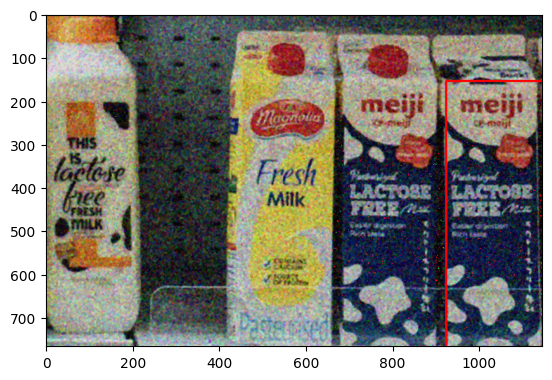


Processing scene8
Product ref17 - 3 instance(s) found:
Instance 1: position: (1341, 581), width: 326px, height: 854px
Instance 2: position: (1341, 581), width: 326px, height: 854px
Instance 3: position: (1341, 581), width: 326px, height: 854px
Product ref23 - 3 instance(s) found:
Instance 1: position: (1358, 626), width: 362px, height: 976px
Instance 2: position: (1358, 626), width: 362px, height: 976px
Instance 3: position: (1358, 626), width: 362px, height: 976px
Product ref24 - 3 instance(s) found:
Instance 1: position: (1358, 635), width: 368px, height: 956px
Instance 2: position: (1358, 635), width: 368px, height: 956px
Instance 3: position: (1358, 635), width: 368px, height: 956px




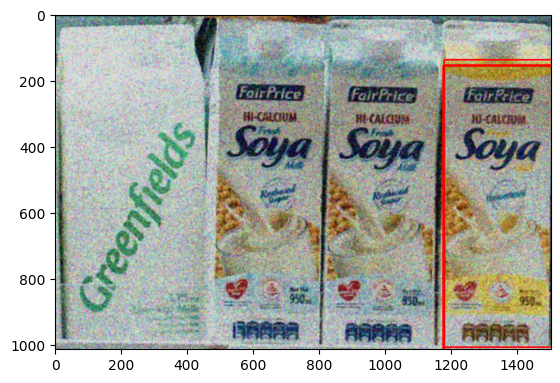


Processing scene9
Product ref19 - 2 instance(s) found:
Instance 1: position: (875, 438), width: 270px, height: 670px
Instance 2: position: (875, 438), width: 270px, height: 670px
Product ref20 - 1 instance(s) found:
Instance 1: position: (1386, 437), width: 278px, height: 671px




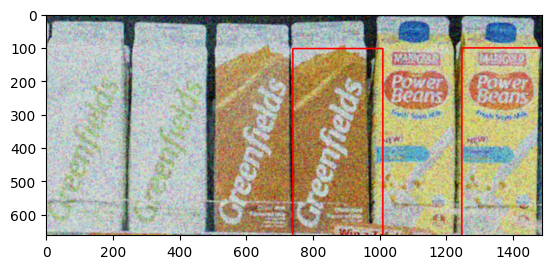

In [160]:
scenes_dir = "dataset/scenes"
models_dir = "dataset/models"

model_images, scene_images = load_images(models_dir, scenes_dir, 'B')

# Preprocess the images
denoised_scenes = preprocess_images(scene_images)

for scene_name, scene_img in denoised_scenes.items():
  print(f"\nProcessing {scene_name}")
  results = {}

  for model_name, model_img  in model_images.items():
    bounding_boxes = template_matching(scene_img, model_img)

    if bounding_boxes:
      product_id = os.path.splitext(model_name)[0]  # Extract product ID from filename
      results[product_id] = {
          "instances_found": len(bounding_boxes),
          "bounding_boxes": bounding_boxes
          }
  generate_output(results, scene_img, show_bounding_boxes = True)